# Depth Image Resize Interpolation 비교

이 노트북은 depth 이미지를 resize할 때 다양한 interpolation 방법들의 차이를 시각화합니다.

비교할 interpolation 방법:
- **Bilinear** (기본값): 선형 보간, 부드러운 결과
- **Nearest**: 가장 가까운 픽셀 값 사용, 계단 현상 발생
- **Bicubic**: 3차 보간, 더 부드러운 결과

**Depth 이미지에서 중요한 점:**
- Depth 값은 실제 거리를 나타내므로, 보간 시 존재하지 않는 값이 생성될 수 있음
- 객체 경계(edge)에서 값의 혼합이 발생하면 부정확한 depth 값이 생성됨
- Nearest interpolation이 원본 값을 유지하여 더 정확할 수 있음


In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path

print(f"PyTorch version: {torch.__version__}")


PyTorch version: 2.5.1+cu124


## 1. 데이터셋 경로 설정 및 샘플 로드


In [ ]:
# 데이터셋 경로
dataset_root = '/root/dev/data/dataset/Batvision/BatvisionV2'

# 사용 가능한 locations
locations = [
    "2ndFloorLuxembourg",
    "3rd_Floor_Luxembourg",
    "Attic",
    "Outdoor_Cobblestone_Path",
    "Salle_Chevalier",
    "Salle_des_Colonnes",
    "V119_Cake_Corridors"
]

# 첫 번째 location에서 샘플 로드
location = locations[0]
csv_path = os.path.join(dataset_root, location, 'train.csv')
df = pd.read_csv(csv_path)

print(f"Location: {location}")
print(f"Total samples: {len(df)}")
print(f"\nDataFrame columns: {df.columns.tolist()}")
print(f"\nFirst sample:")
print(df.iloc[0])


Location: 2ndFloorLuxembourg
Total samples: 431

DataFrame columns: ['index', 'time', 'left audio time', 'right audio time', 'audio path', 'audio file name', 'camera time', 'camera path', 'camera file name', 'depth time', 'depth path', 'depth file name']

First sample:
index                                        0
time                          1662459158.49745
left audio time               1662459158.49745
right audio time              1662459158.49745
audio path           2ndFloorLuxembourg/audio/
audio file name                    audio_0.wav
camera time                  1662459158.455387
camera path         2ndFloorLuxembourg/camera/
camera file name                 camera_0.jpeg
depth time                   1662459158.455387
depth path           2ndFloorLuxembourg/depth/
depth file name                    depth_0.npy
Name: 0, dtype: object


## 2. Depth 이미지 로드 함수


In [ ]:
def load_depth_image(depth_path, as_tensor=False):
    """
    Depth 이미지를 로드합니다.
    
    Args:
        depth_path: depth 이미지 경로 (.npy or image file)
        as_tensor: True면 torch.Tensor로 반환, False면 numpy array로 반환
    
    Returns:
        depth image (numpy array or torch.Tensor)
    """
    # .npy 파일인지 확인
    if depth_path.endswith('.npy'):
        # NumPy 파일 로드
        depth = np.load(depth_path)
    else:
        # 이미지 파일 로드 (16-bit 또는 32-bit)
        depth = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH | cv2.IMREAD_ANYCOLOR)
        
        if depth is None:
            raise RuntimeError(f"Could not load depth image: {depth_path}")
        
        # Grayscale로 변환 (이미 grayscale이면 그대로)
        if len(depth.shape) == 3:
            depth = cv2.cvtColor(depth, cv2.COLOR_BGR2GRAY)
    
    # float32로 변환
    depth = depth.astype(np.float32)
    
    if as_tensor:
        # numpy array를 torch tensor로 변환
        depth_tensor = torch.from_numpy(depth).float()
        # Add channel dimension: (H, W) -> (1, H, W)
        if depth_tensor.dim() == 2:
            depth_tensor = depth_tensor.unsqueeze(0)
        return depth_tensor
    
    return depth

# 샘플 depth 이미지 로드
sample_idx = 0
sample = df.iloc[sample_idx]

# Depth 파일 경로 구성
depth_rel_path = sample['depth path']
depth_filename = sample['depth file name']
depth_path = os.path.join(dataset_root, depth_rel_path, depth_filename)

print(f"Depth path: {depth_path}")
print(f"File exists: {os.path.exists(depth_path)}")

# 원본 depth 이미지 로드
original_depth = load_depth_image(depth_path, as_tensor=False)
print(f"\nOriginal depth shape: {original_depth.shape}")
print(f"Depth value range: [{original_depth.min():.2f}, {original_depth.max():.2f}]")
print(f"Depth dtype: {original_depth.dtype}")


Depth path: /root/dev/data/dataset/Batvision/BatvisionV2/2ndFloorLuxembourg/depth/depth_0.npy
File exists: True

Original depth shape: (720, 1280)
Depth value range: [0.00, 11929.00]
Depth dtype: float32


## 3. 다양한 Interpolation 방법으로 Resize


In [ ]:
# Target size
target_size = 256

# Tensor로 변환
depth_tensor = load_depth_image(depth_path, as_tensor=True)

print(f"Depth tensor shape: {depth_tensor.shape}")
print(f"Original size: {depth_tensor.shape[-2:]}")
print(f"Target size: ({target_size}, {target_size})")

# 다양한 interpolation 방법으로 resize
interpolation_methods = {
    'Original': depth_tensor,
    'Bilinear (기본)': F.resize(depth_tensor, (target_size, target_size), 
                              interpolation=transforms.InterpolationMode.BILINEAR),
    'Nearest': F.resize(depth_tensor, (target_size, target_size), 
                       interpolation=transforms.InterpolationMode.NEAREST),
    'Bicubic': F.resize(depth_tensor, (target_size, target_size), 
                       interpolation=transforms.InterpolationMode.BICUBIC),
}

# 각 방법의 통계 출력
print("\n=== 각 Interpolation 방법의 통계 ===")
for method_name, depth_resized in interpolation_methods.items():
    print(f"\n{method_name}:")
    print(f"  Shape: {depth_resized.shape}")
    print(f"  Min: {depth_resized.min():.4f}")
    print(f"  Max: {depth_resized.max():.4f}")
    print(f"  Mean: {depth_resized.mean():.4f}")
    print(f"  Std: {depth_resized.std():.4f}")


Depth tensor shape: torch.Size([1, 720, 1280])
Original size: torch.Size([720, 1280])
Target size: (256, 256)

=== 각 Interpolation 방법의 통계 ===

Original:
  Shape: torch.Size([1, 720, 1280])
  Min: 0.0000
  Max: 11929.0000
  Mean: 3076.6145
  Std: 2593.9380

Bilinear (기본):
  Shape: torch.Size([1, 256, 256])
  Min: 0.0000
  Max: 10327.8330
  Mean: 3076.6479
  Std: 2547.5801

Nearest:
  Shape: torch.Size([1, 256, 256])
  Min: 0.0000
  Max: 11929.0000
  Mean: 3080.8369
  Std: 2596.4653

Bicubic:
  Shape: torch.Size([1, 256, 256])
  Min: -578.9459
  Max: 11343.1729
  Mean: 3076.7358
  Std: 2562.0391


## 4. 시각화: 전체 이미지 비교


/tmp/ipykernel_2207833/67048499.py:18: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/67048499.py:18: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/67048499.py:18: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/67048499.py:18: UserWarning: Glyph 48277 (\N{HANGUL SYLLABLE BEOB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/67048499.py:18: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/67048499.py:18: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/envs/evtAnything/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL SYLLA

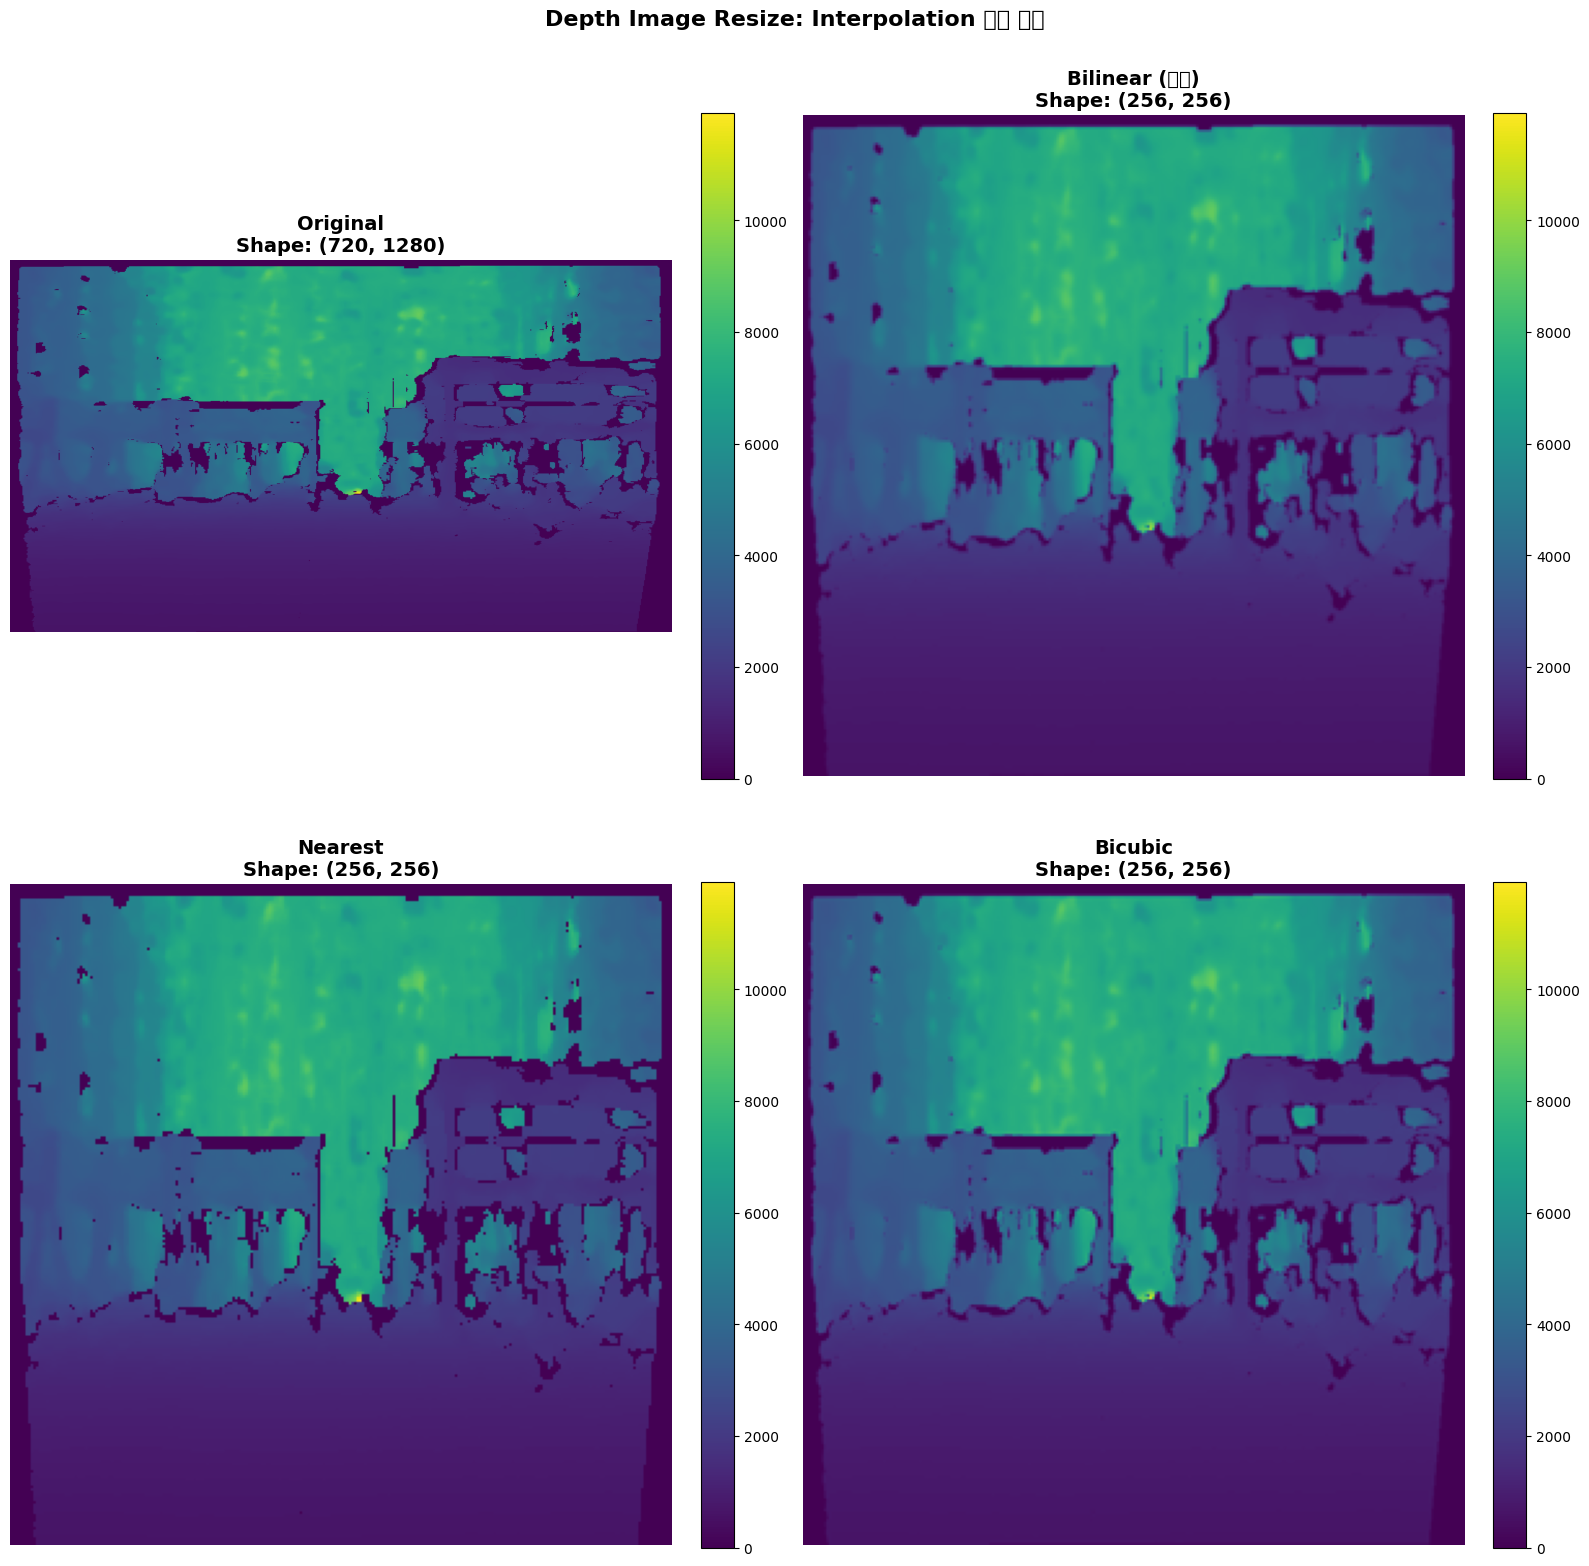

In [ ]:
# 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.flatten()

for idx, (method_name, depth_resized) in enumerate(interpolation_methods.items()):
    # Tensor를 numpy로 변환
    depth_np = depth_resized.squeeze().numpy()
    
    # 시각화
    im = axes[idx].imshow(depth_np, cmap='viridis', vmin=original_depth.min(), vmax=original_depth.max())
    axes[idx].set_title(f'{method_name}\nShape: {depth_np.shape}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')
    
    # Colorbar 추가
    plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)

plt.suptitle('Depth Image Resize: Interpolation 방법 비교', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


## 5. 시각화: 특정 영역 확대 비교 (Edge 부분)


ROI 좌표: y[96:160], x[96:160]


/tmp/ipykernel_2207833/174293132.py:30: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/174293132.py:30: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/174293132.py:30: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/174293132.py:30: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/174293132.py:30: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/174293132.py:30: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/174293132.py:30: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.

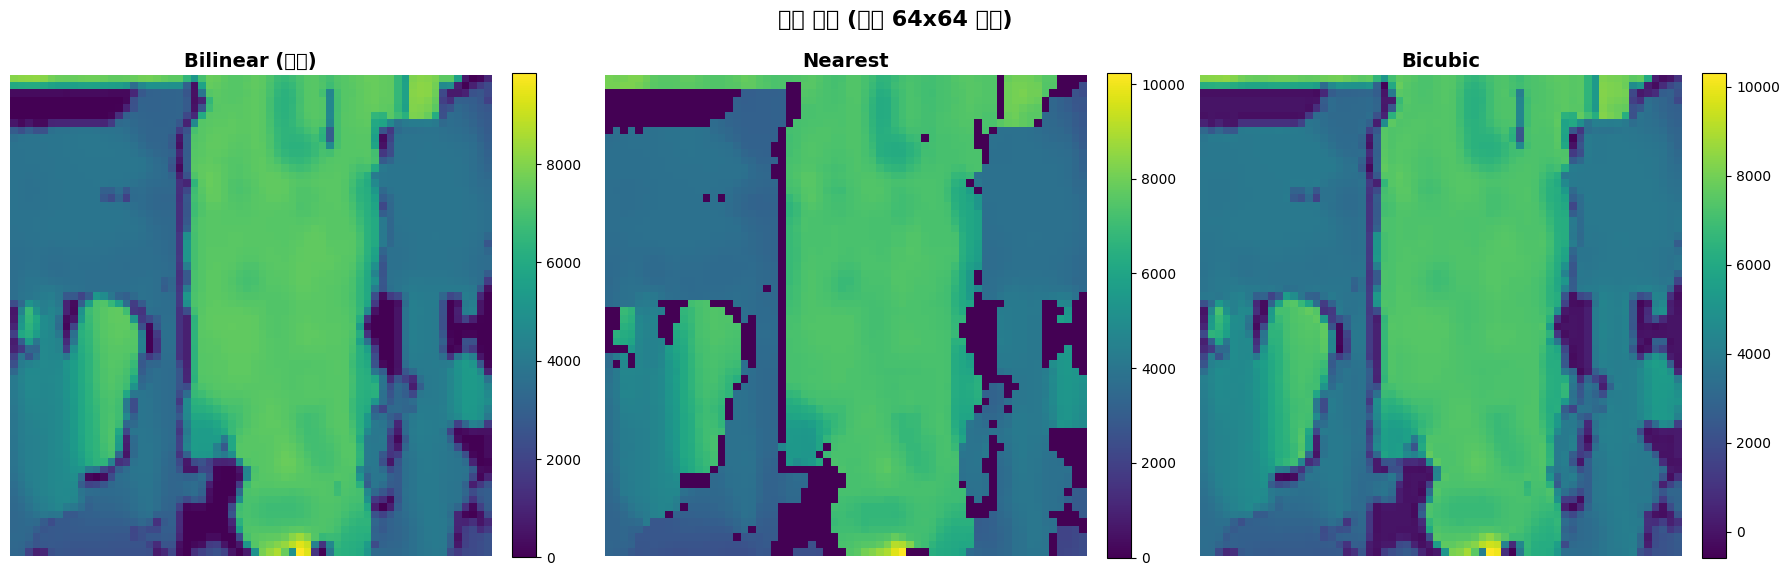

In [ ]:
# 관심 영역(ROI) 설정 - 중앙 부분을 확대
roi_size = 64  # ROI의 크기
center_y, center_x = target_size // 2, target_size // 2

# ROI 좌표
y1, y2 = center_y - roi_size // 2, center_y + roi_size // 2
x1, x2 = center_x - roi_size // 2, center_x + roi_size // 2

print(f"ROI 좌표: y[{y1}:{y2}], x[{x1}:{x2}]")

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

methods_to_compare = ['Bilinear (기본)', 'Nearest', 'Bicubic']

for idx, method_name in enumerate(methods_to_compare):
    depth_resized = interpolation_methods[method_name]
    depth_np = depth_resized.squeeze().numpy()
    
    # ROI 추출
    roi = depth_np[y1:y2, x1:x2]
    
    # 시각화
    im = axes[idx].imshow(roi, cmap='viridis', interpolation='none')
    axes[idx].set_title(f'{method_name}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')
    plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)

plt.suptitle(f'확대 비교 (중앙 {roi_size}x{roi_size} 영역)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


## 6. 차이 맵(Difference Map) 시각화



Nearest vs Bilinear:
  Mean absolute difference: 130.724899
  Max absolute difference: 10248.339844
  Std of difference: 471.751740

Bicubic vs Bilinear:
  Mean absolute difference: 23.398941
  Max absolute difference: 1015.339844
  Std of difference: 61.750553


/tmp/ipykernel_2207833/3309645075.py:27: UserWarning: Glyph 51208 (\N{HANGUL SYLLABLE JEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/3309645075.py:27: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/3309645075.py:27: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/3309645075.py:27: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/3309645075.py:27: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/3309645075.py:27: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/3309645075.py:27: UserWarning: Glyph 47605 (\N{HANGUL SYLLABLE MAEB}) missing from font(s) DejaVu

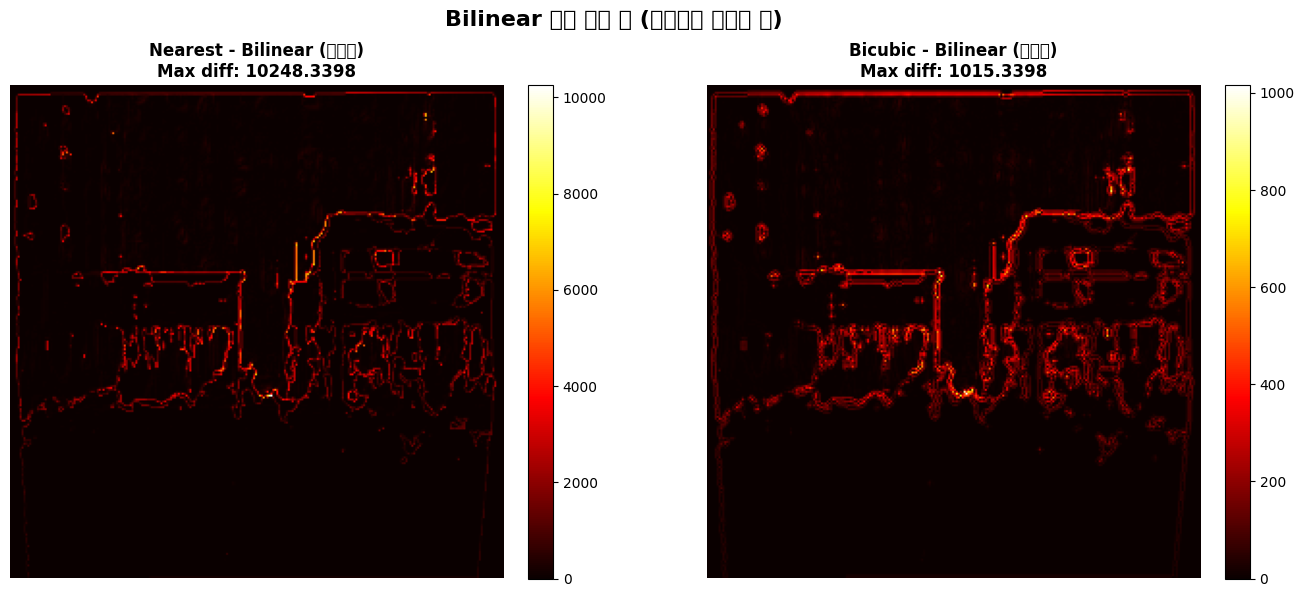

In [ ]:
# Bilinear를 기준으로 다른 방법들과의 차이 계산
baseline = interpolation_methods['Bilinear (기본)'].squeeze().numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

compare_methods = ['Nearest', 'Bicubic']

for idx, method_name in enumerate(compare_methods):
    depth_np = interpolation_methods[method_name].squeeze().numpy()
    
    # 차이 계산 (절대값)
    diff = np.abs(depth_np - baseline)
    
    # 시각화
    im = axes[idx].imshow(diff, cmap='hot')
    axes[idx].set_title(f'{method_name} - Bilinear (절대값)\nMax diff: {diff.max():.4f}', 
                       fontsize=12, fontweight='bold')
    axes[idx].axis('off')
    plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
    
    print(f"\n{method_name} vs Bilinear:")
    print(f"  Mean absolute difference: {diff.mean():.6f}")
    print(f"  Max absolute difference: {diff.max():.6f}")
    print(f"  Std of difference: {diff.std():.6f}")

plt.suptitle('Bilinear 대비 차이 맵 (밝을수록 차이가 큼)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


## 7. 라인 프로파일 비교 (1D 단면)


/tmp/ipykernel_2207833/533222849.py:34: UserWarning: Glyph 51340 (\N{HANGUL SYLLABLE JWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/533222849.py:34: UserWarning: Glyph 54364 (\N{HANGUL SYLLABLE PYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/533222849.py:34: UserWarning: Glyph 54589 (\N{HANGUL SYLLABLE PIG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/533222849.py:34: UserWarning: Glyph 49472 (\N{HANGUL SYLLABLE SEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/533222849.py:34: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/533222849.py:34: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/533222849.py:34: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans

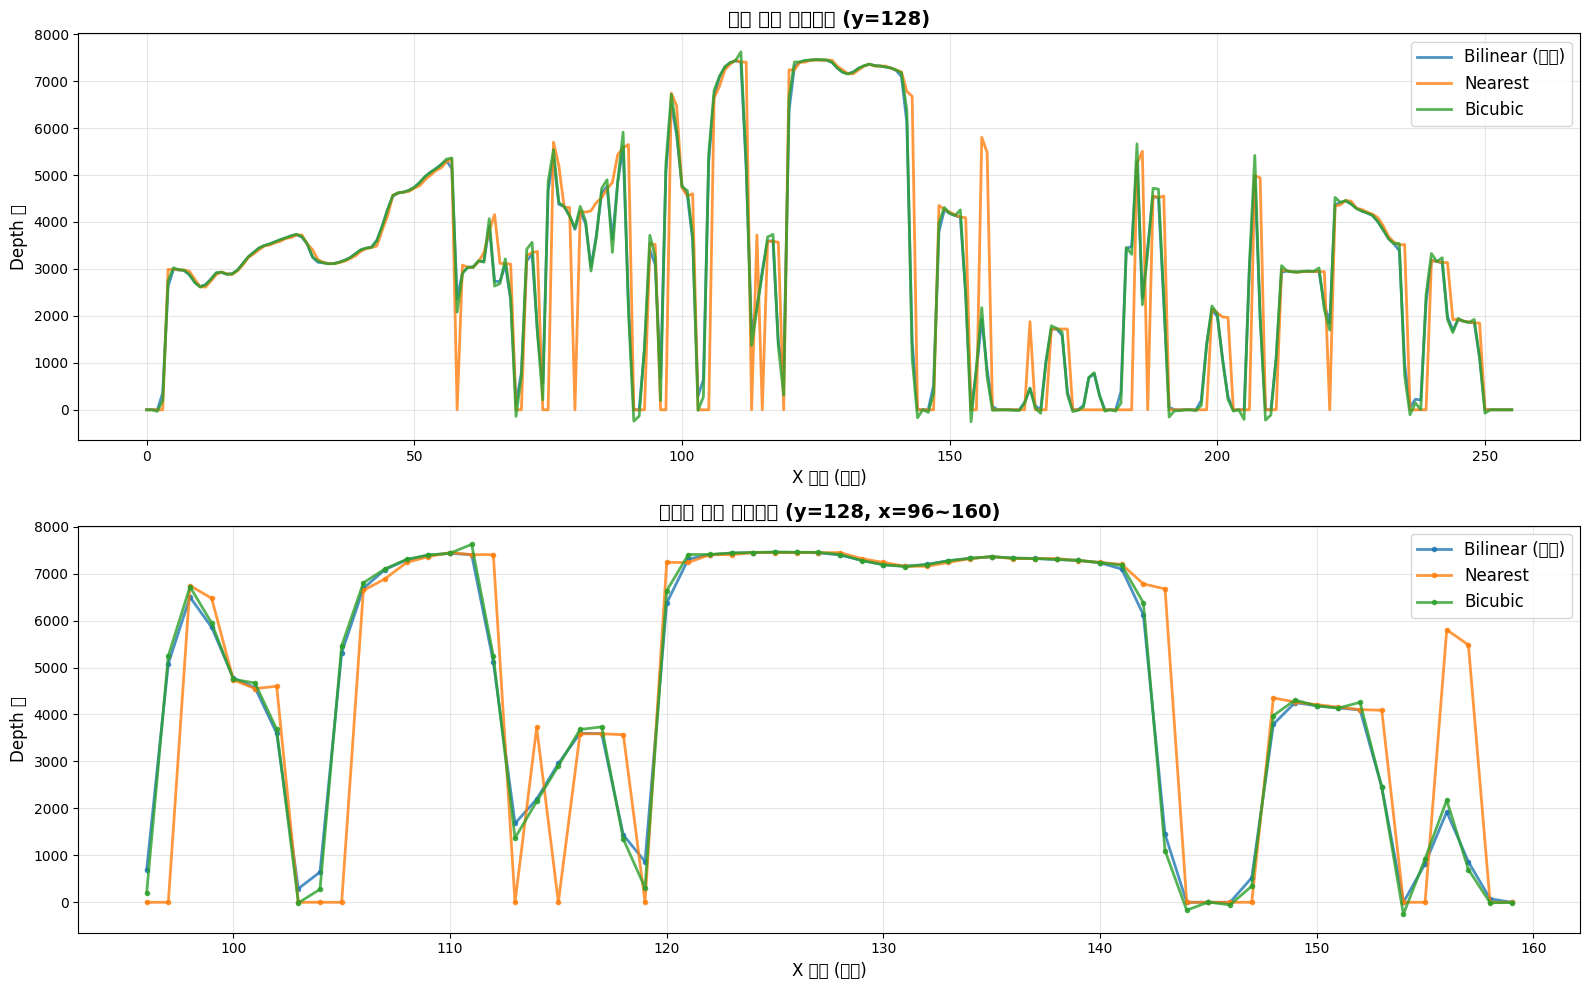


주목할 점:
- Nearest: 계단 형태의 값 유지 (원본 픽셀 값을 그대로 사용)
- Bilinear: 부드러운 선형 보간
- Bicubic: 가장 부드러운 곡선 (3차 보간)


In [ ]:
# 중앙 가로줄의 depth 값을 비교
line_y = target_size // 2

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# 전체 라인
for method_name in ['Bilinear (기본)', 'Nearest', 'Bicubic']:
    depth_np = interpolation_methods[method_name].squeeze().numpy()
    line_profile = depth_np[line_y, :]
    axes[0].plot(line_profile, label=method_name, linewidth=2, alpha=0.8)

axes[0].set_xlabel('X 좌표 (픽셀)', fontsize=12)
axes[0].set_ylabel('Depth 값', fontsize=12)
axes[0].set_title(f'전체 라인 프로파일 (y={line_y})', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

# 확대된 부분 (중앙 64픽셀)
x_start, x_end = center_x - 32, center_x + 32

for method_name in ['Bilinear (기본)', 'Nearest', 'Bicubic']:
    depth_np = interpolation_methods[method_name].squeeze().numpy()
    line_profile = depth_np[line_y, x_start:x_end]
    axes[1].plot(range(x_start, x_end), line_profile, label=method_name, 
                linewidth=2, alpha=0.8, marker='o', markersize=3)

axes[1].set_xlabel('X 좌표 (픽셀)', fontsize=12)
axes[1].set_ylabel('Depth 값', fontsize=12)
axes[1].set_title(f'확대된 라인 프로파일 (y={line_y}, x={x_start}~{x_end})', 
                 fontsize=14, fontweight='bold')
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n주목할 점:")
print("- Nearest: 계단 형태의 값 유지 (원본 픽셀 값을 그대로 사용)")
print("- Bilinear: 부드러운 선형 보간")
print("- Bicubic: 가장 부드러운 곡선 (3차 보간)")


## 8. 히스토그램 비교


/tmp/ipykernel_2207833/1695848374.py:24: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/1695848374.py:24: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/1695848374.py:24: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/1695848374.py:24: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/1695848374.py:24: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/1695848374.py:24: UserWarning: Glyph 55176 (\N{HANGUL SYLLABLE HI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/1695848374.py:24: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu 

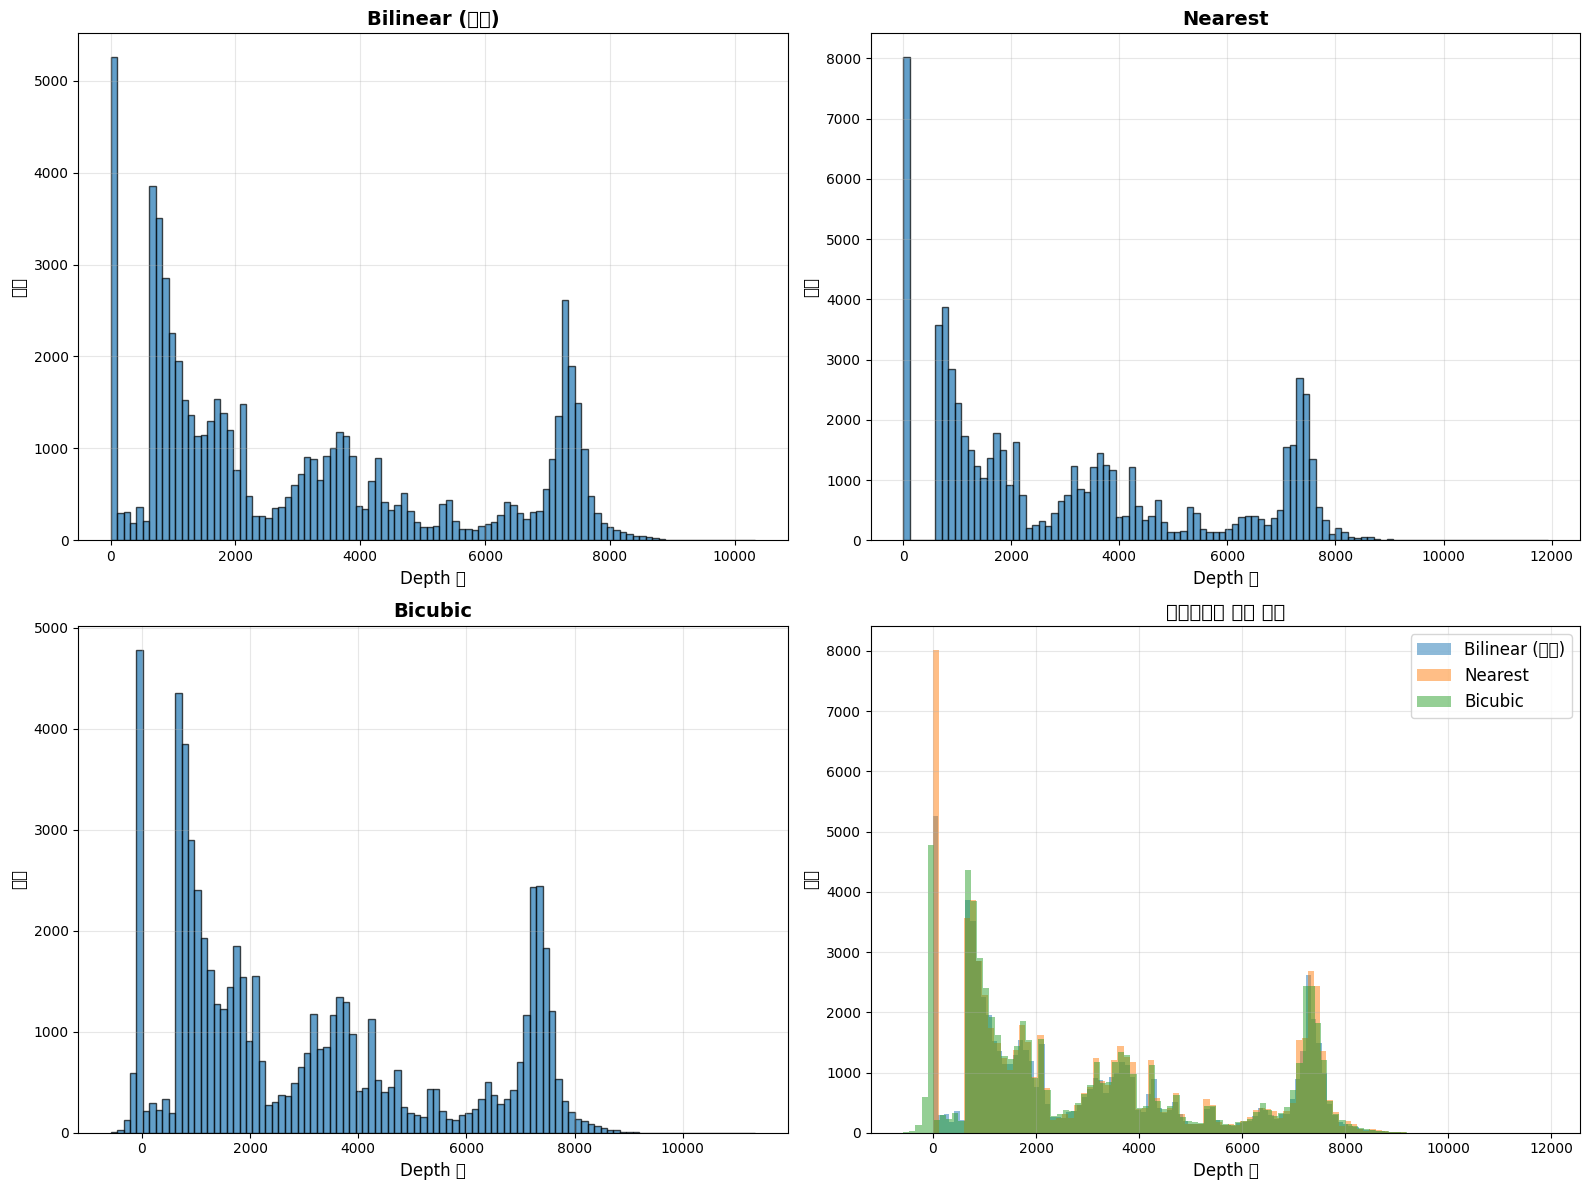


히스토그램 분석:
- Nearest: 원본 픽셀 값만 사용하므로 더 discrete한 분포
- Bilinear/Bicubic: 보간으로 인해 더 연속적인 분포


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# 전체 히스토그램
for idx, method_name in enumerate(['Bilinear (기본)', 'Nearest', 'Bicubic']):
    depth_np = interpolation_methods[method_name].squeeze().numpy()
    axes[idx].hist(depth_np.flatten(), bins=100, alpha=0.7, edgecolor='black')
    axes[idx].set_xlabel('Depth 값', fontsize=12)
    axes[idx].set_ylabel('빈도', fontsize=12)
    axes[idx].set_title(f'{method_name}', fontsize=14, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

# 중첩 비교
for method_name in ['Bilinear (기본)', 'Nearest', 'Bicubic']:
    depth_np = interpolation_methods[method_name].squeeze().numpy()
    axes[3].hist(depth_np.flatten(), bins=100, alpha=0.5, label=method_name)

axes[3].set_xlabel('Depth 값', fontsize=12)
axes[3].set_ylabel('빈도', fontsize=12)
axes[3].set_title('히스토그램 중첩 비교', fontsize=14, fontweight='bold')
axes[3].legend(fontsize=12)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n히스토그램 분석:")
print("- Nearest: 원본 픽셀 값만 사용하므로 더 discrete한 분포")
print("- Bilinear/Bicubic: 보간으로 인해 더 연속적인 분포")


## 9. 여러 샘플에서 비교


/tmp/ipykernel_2207833/494159563.py:48: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/494159563.py:48: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/494159563.py:48: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/494159563.py:48: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/494159563.py:48: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/494159563.py:48: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2207833/494159563.py:48: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.


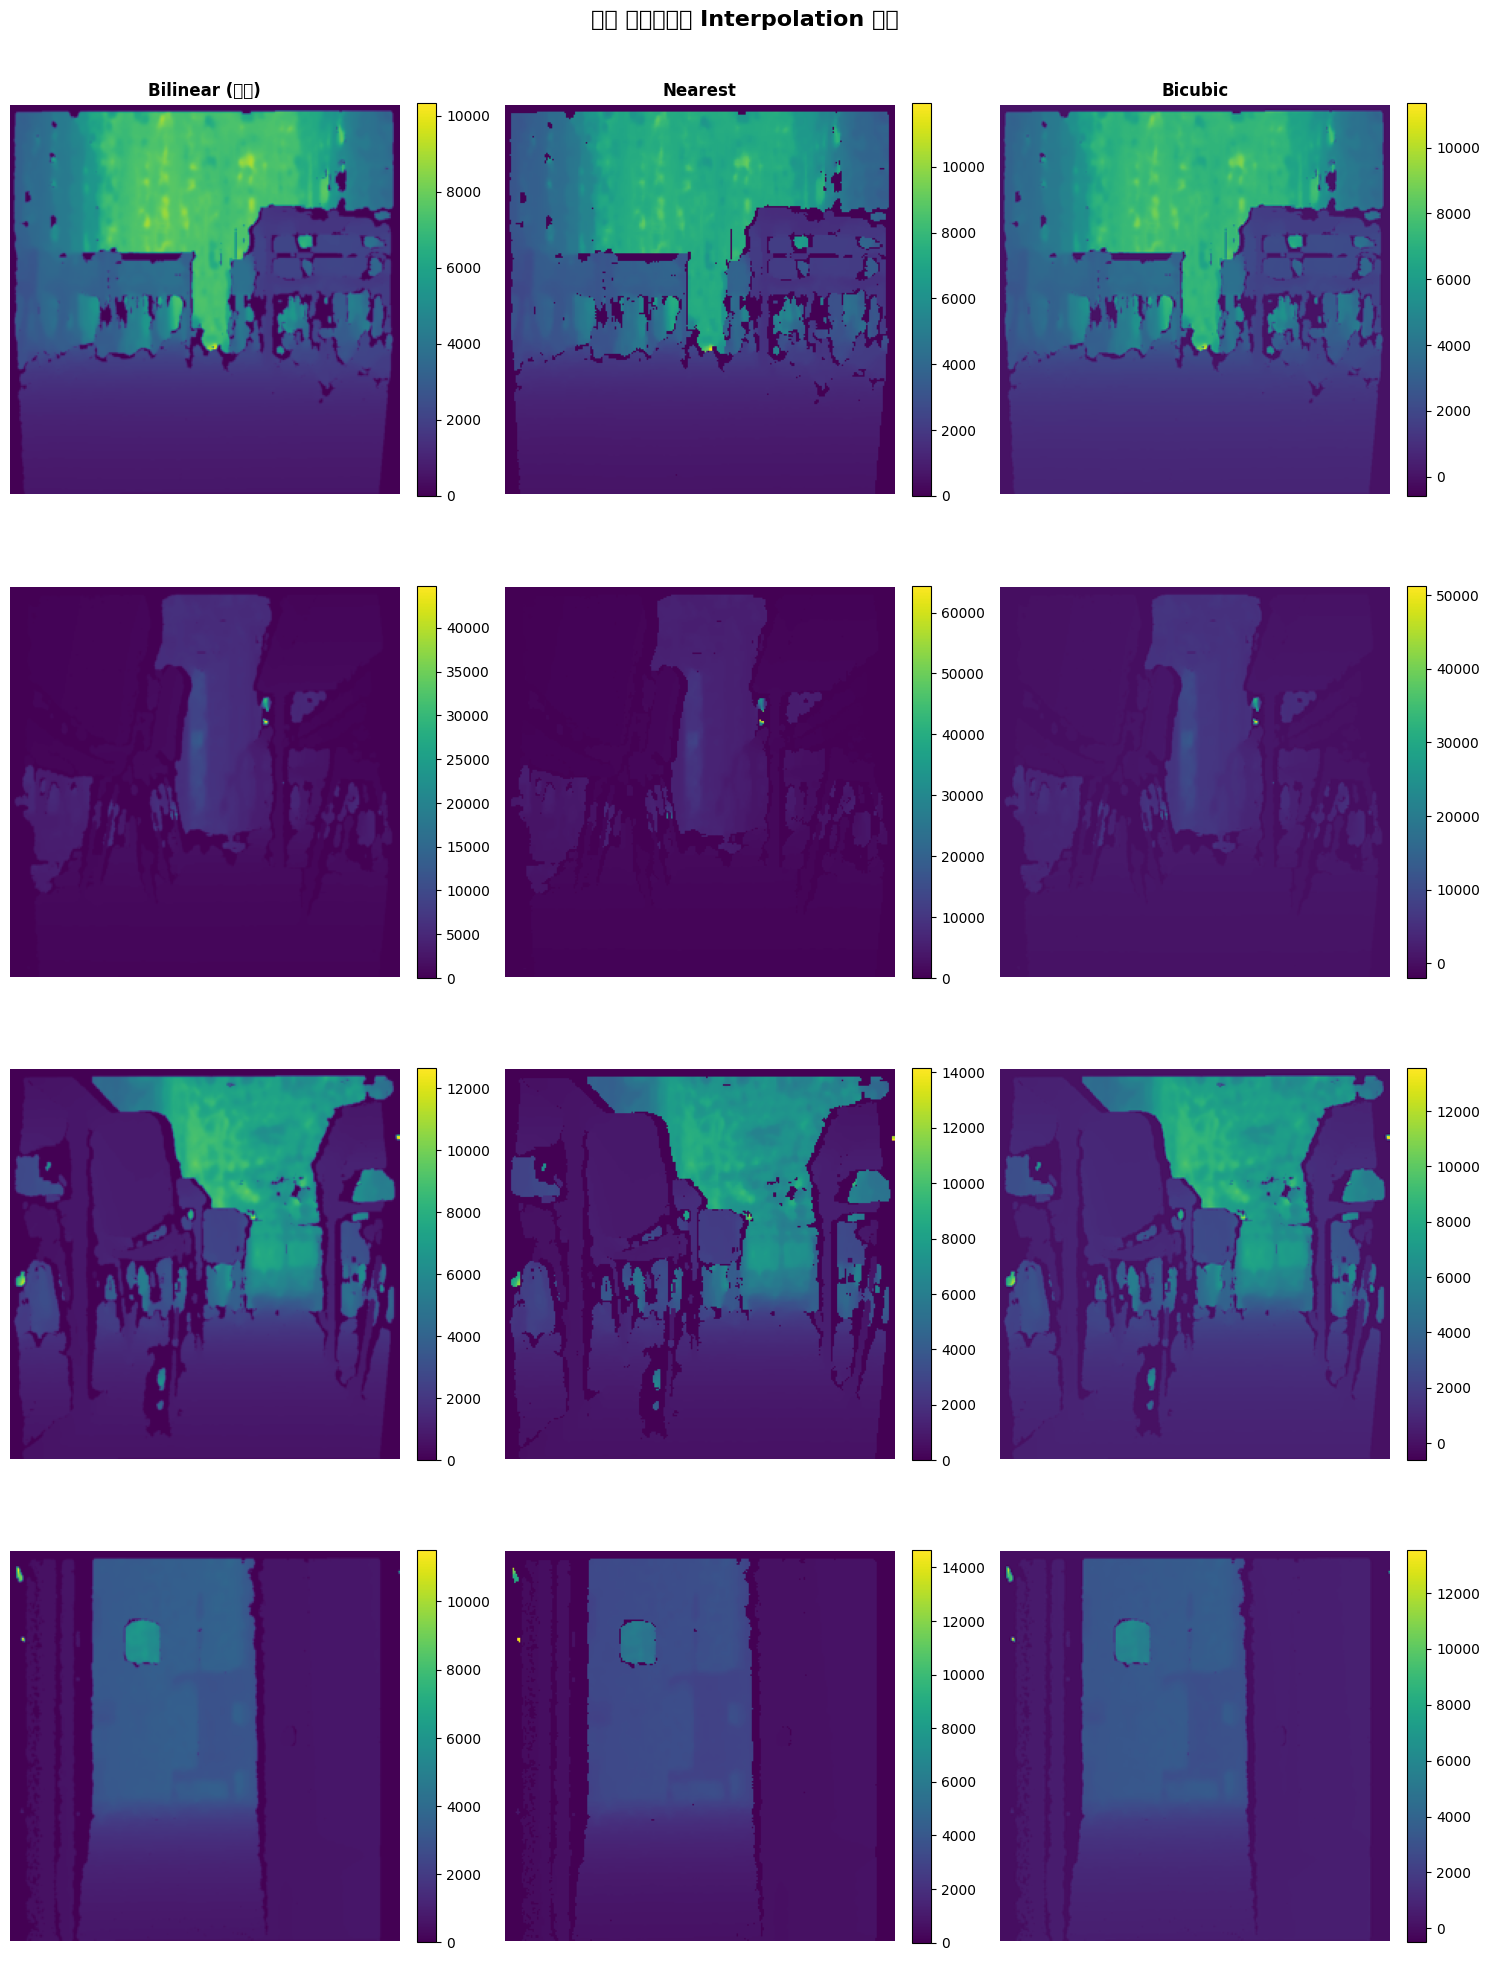

In [ ]:
# 여러 샘플 로드 및 비교
num_samples = 4
sample_indices = np.linspace(0, len(df)-1, num_samples, dtype=int)

fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))

if num_samples == 1:
    axes = axes.reshape(1, -1)

for row_idx, sample_idx in enumerate(sample_indices):
    sample = df.iloc[sample_idx]
    depth_rel_path = sample['depth path']
    depth_filename = sample['depth file name']
    depth_path = os.path.join(dataset_root, depth_rel_path, depth_filename)
    
    if not os.path.exists(depth_path):
        print(f"Skipping sample {sample_idx}: file not found")
        continue
    
    # Depth 로드
    depth_tensor = load_depth_image(depth_path, as_tensor=True)
    
    # 각 interpolation 방법으로 resize
    methods = ['Bilinear (기본)', 'Nearest', 'Bicubic']
    interpolation_modes = [
        transforms.InterpolationMode.BILINEAR,
        transforms.InterpolationMode.NEAREST,
        transforms.InterpolationMode.BICUBIC,
    ]
    
    for col_idx, (method_name, interp_mode) in enumerate(zip(methods, interpolation_modes)):
        depth_resized = F.resize(depth_tensor, (target_size, target_size), 
                                interpolation=interp_mode)
        depth_np = depth_resized.squeeze().numpy()
        
        im = axes[row_idx, col_idx].imshow(depth_np, cmap='viridis')
        
        if row_idx == 0:
            axes[row_idx, col_idx].set_title(method_name, fontsize=12, fontweight='bold')
        
        if col_idx == 0:
            axes[row_idx, col_idx].set_ylabel(f'Sample {sample_idx}', fontsize=10, fontweight='bold')
        
        axes[row_idx, col_idx].axis('off')
        plt.colorbar(im, ax=axes[row_idx, col_idx], fraction=0.046, pad=0.04)

plt.suptitle('여러 샘플에서의 Interpolation 비교', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


## 10. 결론 및 권장사항

### Interpolation 방법별 특징:

1. **Nearest Neighbor**
   - **장점**: 원본 depth 값을 정확히 유지, 빠른 처리 속도
   - **단점**: 계단 현상(aliasing), 시각적으로 거칠게 보임
   - **적합한 경우**: Depth 값의 정확성이 중요한 경우, semantic segmentation

2. **Bilinear (기본값)**
   - **장점**: 부드러운 결과, 빠른 처리 속도
   - **단점**: 객체 경계에서 부정확한 depth 값 생성, 블러링
   - **적합한 경우**: 일반적인 이미지 처리, 시각화

3. **Bicubic**
   - **장점**: 가장 부드러운 결과, 고품질
   - **단점**: 느린 처리 속도, depth 값의 overshooting/undershooting 가능
   - **적합한 경우**: 고품질 시각화가 필요한 경우

### Depth 이미지에 대한 권장사항:

**Nearest interpolation을 사용하는 것을 권장합니다:**
- Depth 값은 물리적 거리를 나타내므로, 보간으로 인한 artifact가 문제가 될 수 있음
- 객체 경계에서 전경과 배경의 depth 값이 혼합되면 부정확한 결과 발생
- 특히 downstream task (3D reconstruction, robot navigation 등)에서 정확한 값이 중요

### 코드 예시:

```python
# Depth 이미지 resize 시 nearest interpolation 사용
transform_list.append(
    transforms.Resize(
        (cfg.dataset.images_size, cfg.dataset.images_size),
        interpolation=transforms.InterpolationMode.NEAREST
    )
)
```
